## 1. Data Generation and Visualization of Nonlinear Boundaries  

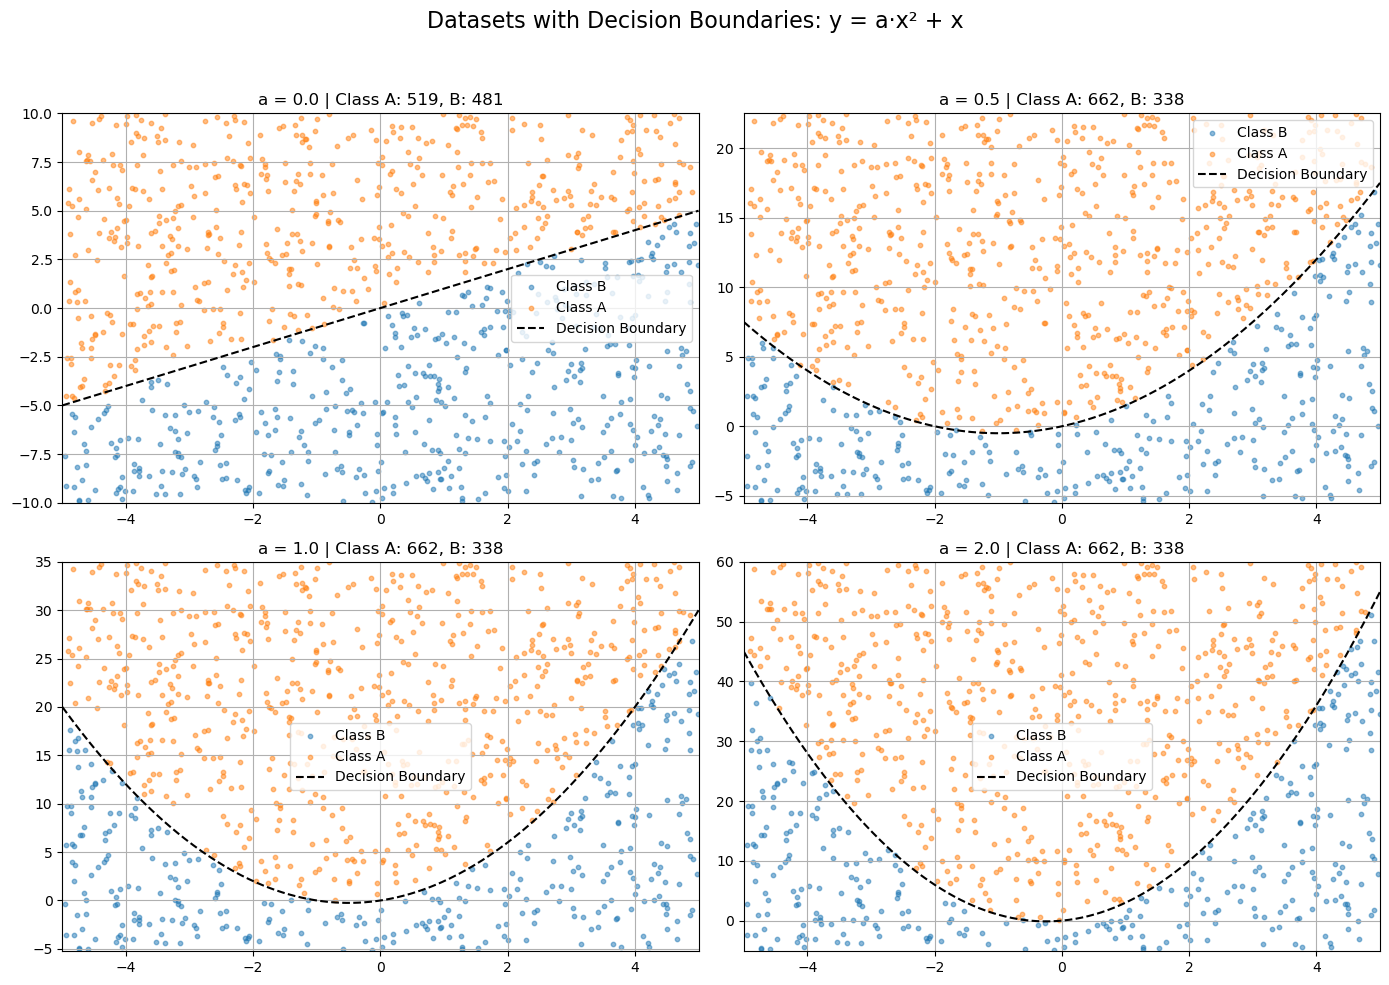

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Data generation function
def generate_dataset(N=1000, a=1.0, x_range=(-3, 3), y_range=(-5, 5), seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    x = np.random.uniform(x_range[0], x_range[1], N)
    y = np.random.uniform(y_range[0], y_range[1], N)
    
    f_x = a * x**2 + x
    labels = (y > f_x).astype(int)
    
    X = np.column_stack((x, y))
    return X, labels

# Automatically calculate the Y-axis range
def calculate_y_range(a, x_range=(-3, 3), margin=2.0):
    x_vals = np.array(x_range)
    y_vals = a * x_vals**2 + x_vals
    y_min, y_max = y_vals.min() - margin, y_vals.max() + margin
    return y_min, y_max

# Generate + draw + save data and images
def generate_and_plot_datasets_with_saving(
    a_values, 
    N=1000, 
    x_range=(-5, 5), 
    margin=5.0, 
    seed=42,
    img_save_path=r"D:\coursework_data\AI_question2\decision_boundaries.png",
    data_save_dir=r"D:\coursework_data\AI_question2"
):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_vals = np.linspace(x_range[0], x_range[1], 400)

    os.makedirs(data_save_dir, exist_ok=True)

    for i, a in enumerate(a_values):
        y_vals_boundary = a * x_vals**2 + x_vals
        y_min, y_max = y_vals_boundary.min() - margin, y_vals_boundary.max() + margin
        y_range = (y_min, y_max)

        X, y = generate_dataset(N=N, a=a, x_range=x_range, y_range=y_range, seed=seed)

        # Save data
        np.savez(os.path.join(data_save_dir, f"dataset_a{a}.npz"), X=X, y=y)

        row, col = divmod(i, 2)
        ax = axs[row, col]
        ax.scatter(X[y==0][:, 0], X[y==0][:, 1], alpha=0.5, label="Class B", s=10)
        ax.scatter(X[y==1][:, 0], X[y==1][:, 1], alpha=0.5, label="Class A", s=10)
        ax.plot(x_vals, y_vals_boundary, color='black', linestyle='--', label='Decision Boundary')

        num_A = np.sum(y == 1)
        num_B = np.sum(y == 0)
        ax.set_title(f"a = {a} | Class A: {num_A}, B: {num_B}")
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.legend()
        ax.grid(True)

    plt.suptitle("Datasets with Decision Boundaries: y = a·x² + x", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    os.makedirs(os.path.dirname(img_save_path), exist_ok=True)
    plt.savefig(img_save_path, dpi=300)
    plt.show()

# Generate
a_values = [0.0, 0.5, 1.0, 2.0]
generate_and_plot_datasets_with_saving(a_values)


## 2. Logistic Regression: Evaluation on Nonlinear Boundaries  

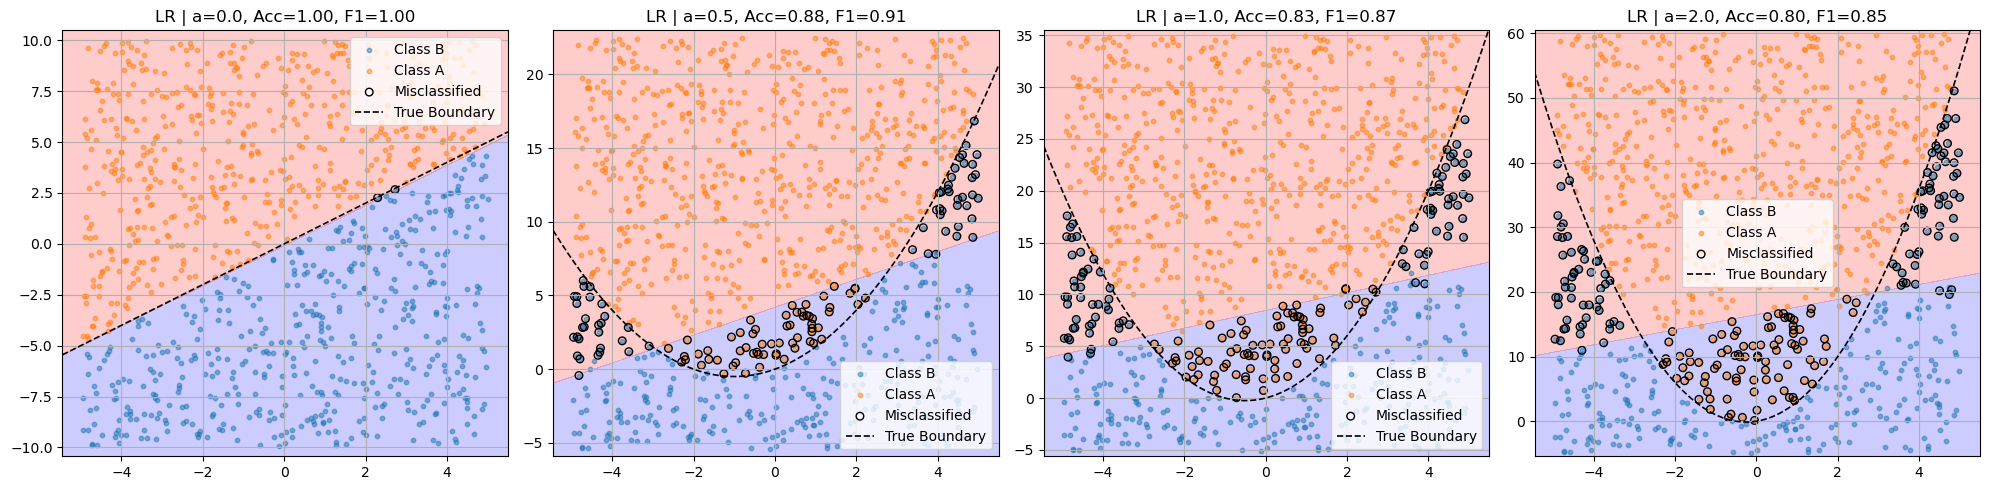

Logistic Regression Accuracy & F1 per a:
a = 0.0 | Acc = 0.998 | F1 = 0.998
a = 0.5 | Acc = 0.875 | F1 = 0.906
a = 1.0 | Acc = 0.829 | F1 = 0.871
a = 2.0 | Acc = 0.803 | F1 = 0.853


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# training + visualization + index analysis
def train_and_plot_logistic_regression(X, y, a, ax=None, save_dir=None):
    # Construct standardization + logistic regression pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])
    
    # Cross-validation prediction and accuracy evaluation (cv=5)
    y_pred = cross_val_predict(model, X, y, cv=5)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)

    # Fitted whole groups are used to visualize boundaries
    model.fit(X, y)

    # Grids are used for decision boundary visualization
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Save prediction
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"logreg_preds_a{a}.npz"),
                 X=X, y_true=y, y_pred=y_pred)

    # Visualize the original classification and error points
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    ax.scatter(X[y==0][:, 0], X[y==0][:, 1], label="Class B", alpha=0.5, s=10)
    ax.scatter(X[y==1][:, 0], X[y==1][:, 1], label="Class A", alpha=0.5, s=10)

    # Mark error classification points
    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label="Misclassified")

    # Add the true boundary y = ax^2 + x
    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = a * x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=1.2, label='True Boundary')

    ax.set_title(f"LR | a={a}, Acc={acc:.2f}, F1={report['1']['f1-score']:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)

    return acc, report, cm

# Main
a_values = [0.0, 0.5, 1.0, 2.0]
data_dir = r"D:\coursework_data\AI_question2"
pred_save_dir = r"D:\coursework_data\AI_question2\logreg_predictions"
img_save_path = r"D:\coursework_data\AI_question2\logreg_results_advanced.png"

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
accuracies, reports, confusion_matrices = {}, {}, {}

for i, a in enumerate(a_values):
    data = np.load(os.path.join(data_dir, f"dataset_a{a}.npz"))
    X, y = data['X'], data['y']
    acc, report, cm = train_and_plot_logistic_regression(X, y, a, ax=axs[i], save_dir=pred_save_dir)
    accuracies[a] = acc
    reports[a] = report
    confusion_matrices[a] = cm

# Save image
plt.tight_layout()
os.makedirs(os.path.dirname(img_save_path), exist_ok=True)
plt.savefig(img_save_path, dpi=300)
plt.show()

# Print summary
print("Logistic Regression Accuracy & F1 per a:")
for a in a_values:
    print(f"a = {a:.1f} | Acc = {accuracies[a]:.3f} | F1 = {reports[a]['1']['f1-score']:.3f}")


In [6]:
print("\nConfusion Matrices per a:")
for a in a_values:
    print(f"\na = {a}:")
    print(confusion_matrices[a])


Confusion Matrices per a:

a = 0.0:
[[479   2]
 [  0 519]]

a = 0.5:
[[275  63]
 [ 62 600]]

a = 1.0:
[[250  88]
 [ 83 579]]

a = 2.0:
[[232 106]
 [ 91 571]]


## 3. Small Neural Network for Nonlinear Classification and model compare

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


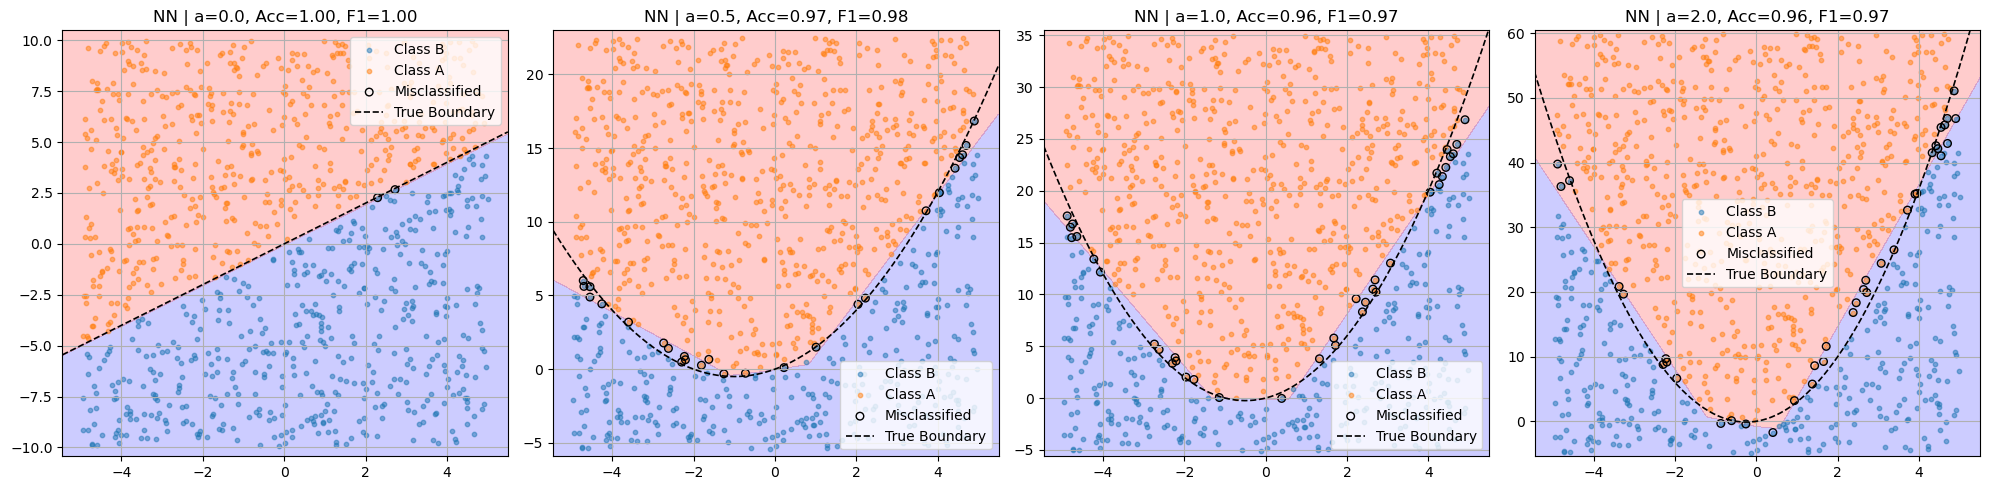

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==============================
# configurate parameters
# ==============================
a_values = [0.0, 0.5, 1.0, 2.0]
data_dir = r"D:\coursework_data\AI_question2"
result_img_path = r"D:\coursework_data\AI_question2\nn_results.png"
result_pred_dir = r"D:\coursework_data\AI_question2\nn_predictions"
result_text_path = r"D:\coursework_data\AI_question2\nn_result_summary.txt"
os.makedirs(result_pred_dir, exist_ok=True)

# ==============================
# Model function definition
# ==============================
def train_and_plot_nn_classifier(X, y, a, ax=None, save_dir=None):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42))
    ])
    
    y_pred = cross_val_predict(model, X, y, cv=5)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)

    model.fit(X, y)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    if save_dir is not None:
        np.savez(os.path.join(save_dir, f"nn_preds_a{a}.npz"),
                 X=X, y_true=y, y_pred=y_pred)

    if ax is not None:
        ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
        ax.scatter(X[y==0][:, 0], X[y==0][:, 1], label="Class B", alpha=0.5, s=10)
        ax.scatter(X[y==1][:, 0], X[y==1][:, 1], label="Class A", alpha=0.5, s=10)
        misclassified = y != y_pred
        ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
                   edgecolor='black', facecolor='none', s=30, label="Misclassified")
        
        # Add the true boundary y = ax^2 + x
        x_vals = np.linspace(x_min, x_max, 300)
        y_vals = a * x_vals**2 + x_vals
        ax.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=1.2, label='True Boundary')
        
        ax.set_title(f"NN | a={a}, Acc={acc:.2f}, F1={report['1']['f1-score']:.2f}")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.grid(True)

    return acc, report, cm

# ==============================
# Main
# ==============================
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
acc_dict, f1_dict, cm_dict = {}, {}, {}

with open(result_text_path, "w", encoding="utf-8") as f:
    for i, a in enumerate(a_values):
        file_path = os.path.join(data_dir, f"dataset_a{a}.npz")
        data = np.load(file_path)
        X, y = data["X"], data["y"]
        acc, report, cm = train_and_plot_nn_classifier(X, y, a, ax=axs[i], save_dir=pred_save_dir)
        acc_dict[a] = acc
        f1_dict[a] = report['1']['f1-score']
        cm_dict[a] = cm

        # Write into text
        f.write(f"a = {a}\n")
        f.write(f"Accuracy: {acc:.3f}, F1-score: {report['1']['f1-score']:.3f}\n")
        f.write("Confusion Matrix:\n")
        f.write(str(cm))
        f.write("\n\n")

plt.tight_layout()
plt.savefig(result_img_path, dpi=300)
plt.show()


In [17]:
# ==============================
# Summary of results
# ==============================
print(" Neural Network Performance Summary:")
print("-" * 50)
for a in a_values:
    print(f"a = {a:.1f}")
    print(f"  Accuracy    : {acc_dict[a]:.3f}")
    print(f"  F1-score(A) : {f1_dict[a]:.3f}")
    print("  Confusion Matrix:")
    print(cm_dict[a])
    print("-" * 50)


 Neural Network Performance Summary:
--------------------------------------------------
a = 0.0
  Accuracy    : 0.998
  F1-score(A) : 0.998
  Confusion Matrix:
[[479   2]
 [  0 519]]
--------------------------------------------------
a = 0.5
  Accuracy    : 0.974
  F1-score(A) : 0.980
  Confusion Matrix:
[[325  13]
 [ 13 649]]
--------------------------------------------------
a = 1.0
  Accuracy    : 0.964
  F1-score(A) : 0.973
  Confusion Matrix:
[[319  19]
 [ 17 645]]
--------------------------------------------------
a = 2.0
  Accuracy    : 0.962
  F1-score(A) : 0.971
  Confusion Matrix:
[[321  17]
 [ 21 641]]
--------------------------------------------------


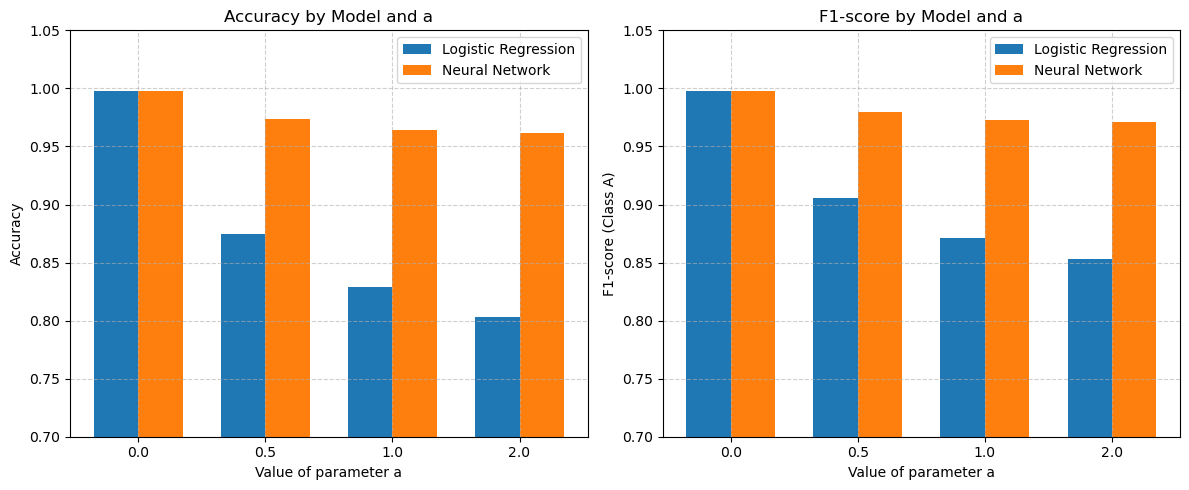

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Data
a_labels = ['0.0', '0.5', '1.0', '2.0']
x = np.arange(len(a_labels))  # x axis

# model performance value
acc_lr = [0.998, 0.875, 0.829, 0.803]
f1_lr = [0.998, 0.906, 0.871, 0.853]
acc_nn = [0.998, 0.974, 0.964, 0.962]
f1_nn = [0.998, 0.980, 0.973, 0.971]

bar_width = 0.35

# Create bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.bar(x - bar_width/2, acc_lr, width=bar_width, label='Logistic Regression')
ax1.bar(x + bar_width/2, acc_nn, width=bar_width, label='Neural Network')
ax1.set_xticks(x)
ax1.set_xticklabels(a_labels)
ax1.set_ylim(0.7, 1.05)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Value of parameter a")
ax1.set_title("Accuracy by Model and a")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# F1-score
ax2.bar(x - bar_width/2, f1_lr, width=bar_width, label='Logistic Regression')
ax2.bar(x + bar_width/2, f1_nn, width=bar_width, label='Neural Network')
ax2.set_xticks(x)
ax2.set_xticklabels(a_labels)
ax2.set_ylim(0.7, 1.05)
ax2.set_ylabel("F1-score (Class A)")
ax2.set_xlabel("Value of parameter a")
ax2.set_title("F1-score by Model and a")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\lr_vs_nn_barchart.png", dpi=300)
plt.show()


## 4. Impact of Sample Size on Model Performance  

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


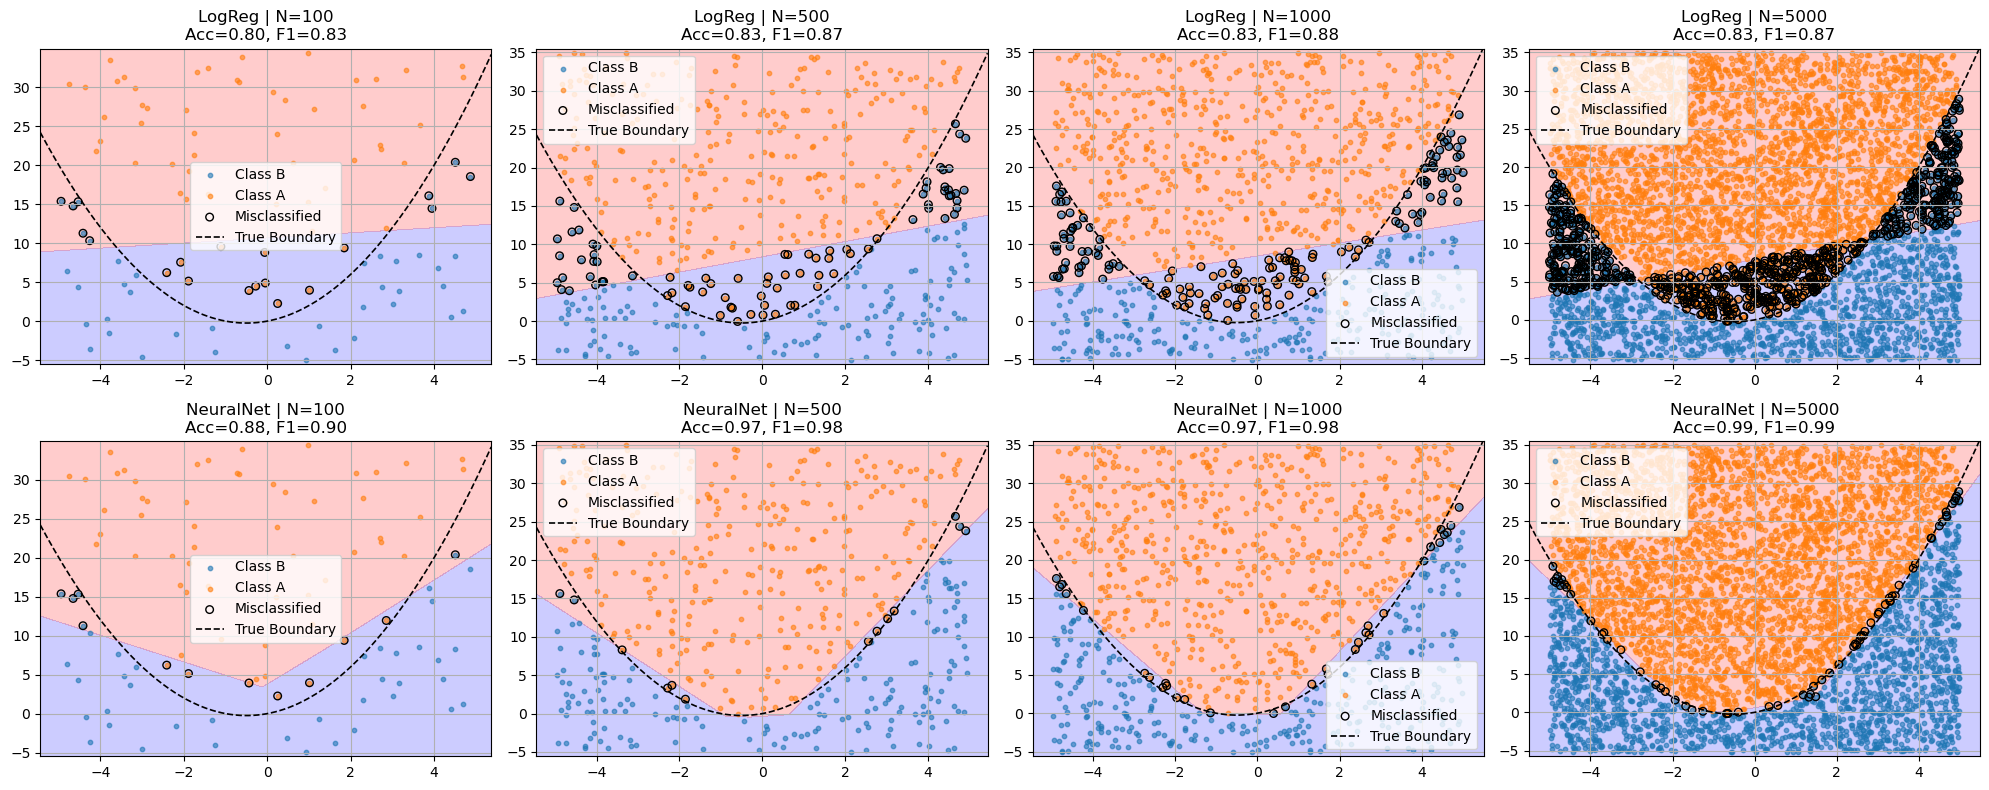

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set parameters
a = 1.0
sample_sizes = [100, 500, 1000, 5000]
x_range = (-5, 5)
margin = 5.0
random_seed = 42

# Generated data function
def generate_dataset(N, a, x_range=(-5, 5), seed=42):
    np.random.seed(seed)
    x_vals = np.linspace(x_range[0], x_range[1], 400)
    y_vals_boundary = a * x_vals**2 + x_vals
    y_min, y_max = y_vals_boundary.min() - margin, y_vals_boundary.max() + margin
    X = np.random.uniform(x_range[0], x_range[1], (N, 1))
    Y = np.random.uniform(y_min, y_max, (N, 1))
    data = np.hstack((X, Y))
    labels = (Y > a * X**2 + X).astype(int).ravel()
    return data, labels

# Plot function
def plot_decision_boundary_with_errors_and_true_boundary(X, y, model, title, ax, a=1.0):
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = classification_report(y, y_pred, output_dict=True)['1']['f1-score']

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])
    ax.scatter(X[y==0][:, 0], X[y==0][:, 1], alpha=0.6, label='Class B', s=10)
    ax.scatter(X[y==1][:, 0], X[y==1][:, 1], alpha=0.6, label='Class A', s=10)
    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label='Misclassified')

    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = a * x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=1.2, label='True Boundary')

    ax.set_title(f"{title}\nAcc={acc:.2f}, F1={f1:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.legend()

# Create figure
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
results_lr = []
results_nn = []

for i, N in enumerate(sample_sizes):
    X, y = generate_dataset(N, a, x_range, seed=random_seed)

    # Logistic Regression
    lr_model = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])
    lr_model.fit(X, y)
    y_pred_lr = lr_model.predict(X)
    acc_lr = accuracy_score(y, y_pred_lr)
    f1_lr = classification_report(y, y_pred_lr, output_dict=True)['1']['f1-score']
    cm_lr = confusion_matrix(y, y_pred_lr)
    results_lr.append((N, acc_lr, f1_lr, cm_lr))
    plot_decision_boundary_with_errors_and_true_boundary(
        X, y, lr_model, f"LogReg | N={N}", axs[0, i], a=a)

    # Neural Network
    nn_model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42))
    ])
    nn_model.fit(X, y)
    y_pred_nn = nn_model.predict(X)
    acc_nn = accuracy_score(y, y_pred_nn)
    f1_nn = classification_report(y, y_pred_nn, output_dict=True)['1']['f1-score']
    cm_nn = confusion_matrix(y, y_pred_nn)
    results_nn.append((N, acc_nn, f1_nn, cm_nn))
    plot_decision_boundary_with_errors_and_true_boundary(
        X, y, nn_model, f"NeuralNet | N={N}", axs[1, i], a=a)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\sample_size_model_comparison_2x4.png", dpi=300)
plt.show()

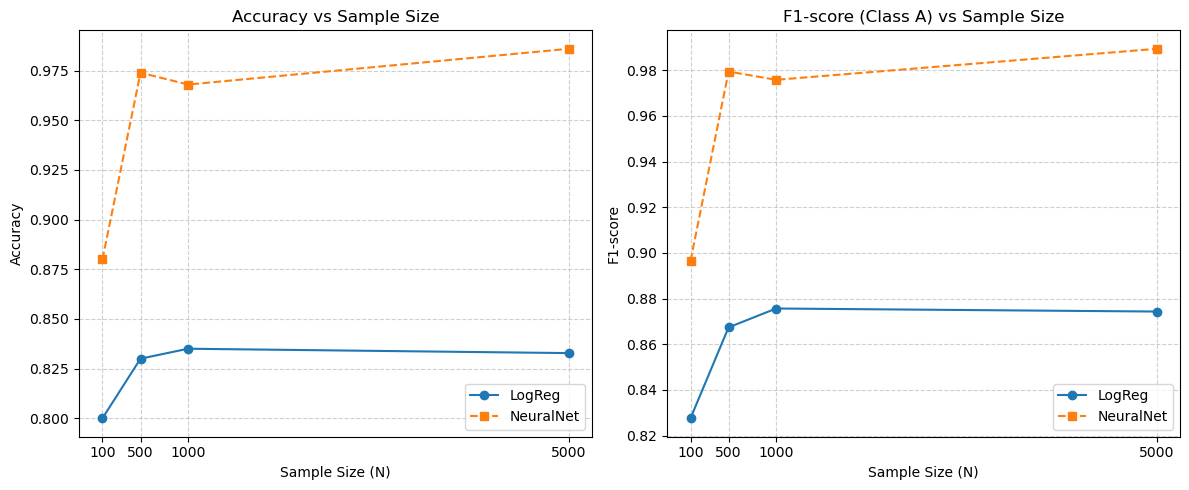

In [22]:
import matplotlib.pyplot as plt

# Extract data
Ns = [r[0] for r in results_lr]
acc_lr = [r[1] for r in results_lr]
f1_lr = [r[2] for r in results_lr]
acc_nn = [r[1] for r in results_nn]
f1_nn = [r[2] for r in results_nn]

# Line chart
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Define ticks to show (only sample sizes)
xticks_to_show = Ns  # 可以换成手动指定的，如 [50, 100, 500, 1000]

# Accuracy plot
axs[0].plot(Ns, acc_lr, marker='o', linestyle='-', label="LogReg")
axs[0].plot(Ns, acc_nn, marker='s', linestyle='--', label="NeuralNet")
axs[0].set_title("Accuracy vs Sample Size")
axs[0].set_xlabel("Sample Size (N)")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(xticks_to_show)
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.6)

# F1-score plot
axs[1].plot(Ns, f1_lr, marker='o', linestyle='-', label="LogReg")
axs[1].plot(Ns, f1_nn, marker='s', linestyle='--', label="NeuralNet")
axs[1].set_title("F1-score (Class A) vs Sample Size")
axs[1].set_xlabel("Sample Size (N)")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(xticks_to_show)
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\sample_size_performance_lineplot.png", dpi=300)
plt.show()


## 5. Impact of Class Imbalance on Model Performance  

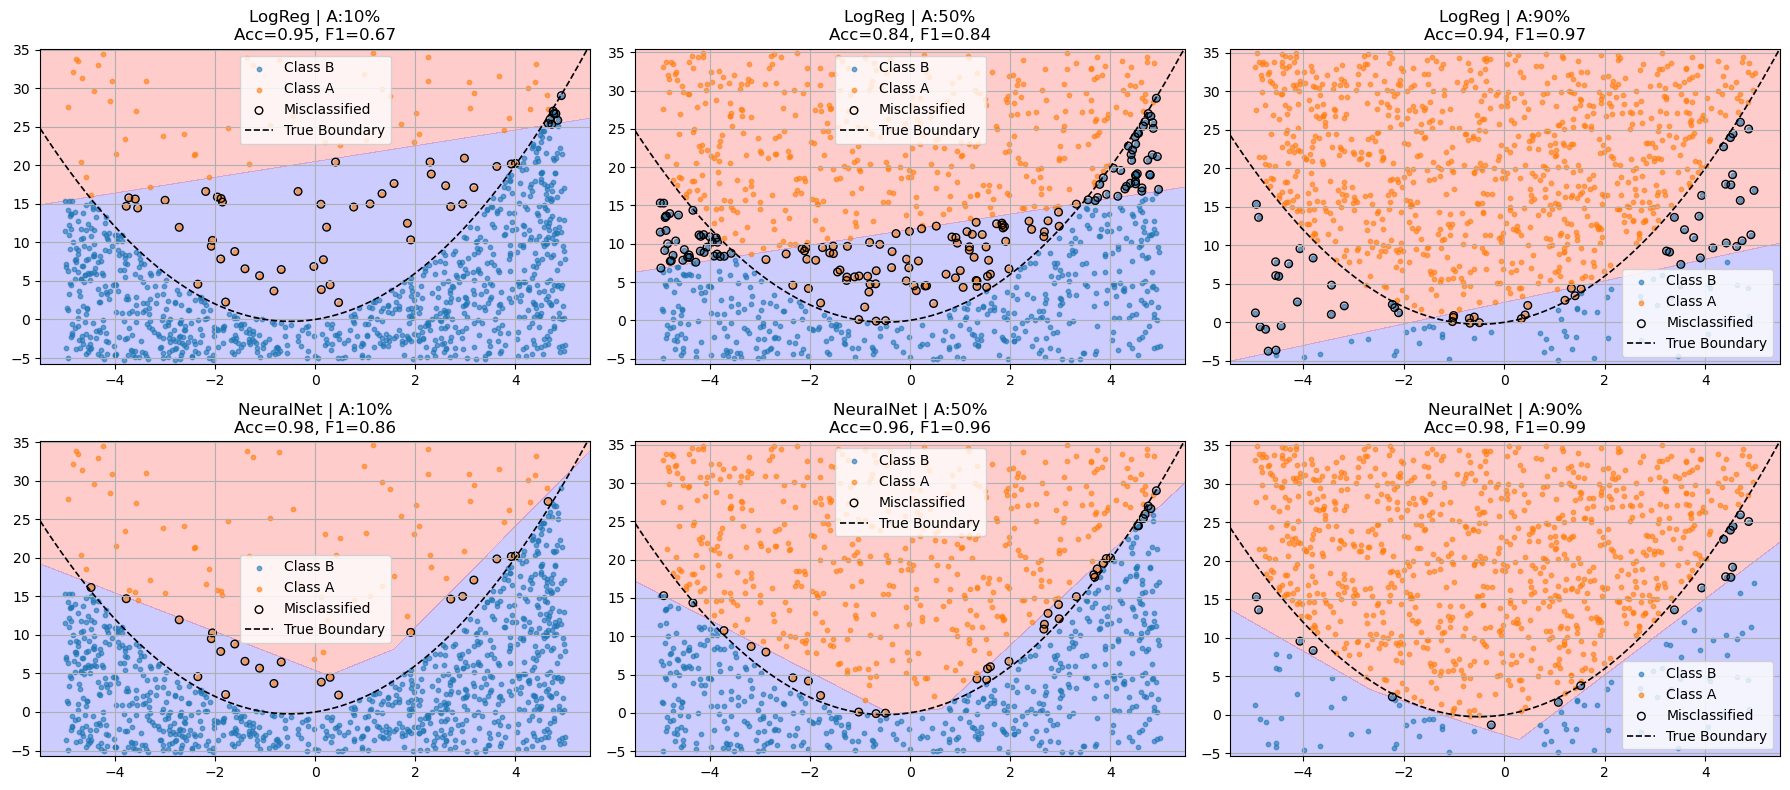

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set parameters
a = 1.0
total_N = 1000
ratios = [(0.1, 0.9), (0.5, 0.5), (0.9, 0.1)]
random_seed = 42

# Generate unbalanced data
def generate_imbalanced_dataset(N, a, pos_ratio, seed=42):
    np.random.seed(seed)
    x_vals = np.linspace(-5, 5, 400)
    y_vals_boundary = a * x_vals**2 + x_vals
    y_min, y_max = y_vals_boundary.min() - 5, y_vals_boundary.max() + 5

    data = []
    labels = []
    pos_needed = int(N * pos_ratio)
    neg_needed = N - pos_needed

    while len(data) < N:
        x = np.random.uniform(-5, 5)
        y = np.random.uniform(y_min, y_max)
        label = int(y > a * x**2 + x)
        if label == 1 and pos_needed > 0:
            data.append([x, y])
            labels.append(1)
            pos_needed -= 1
        elif label == 0 and neg_needed > 0:
            data.append([x, y])
            labels.append(0)
            neg_needed -= 1
    return np.array(data), np.array(labels)

# Plot function
def plot_with_boundary_and_errors(X, y, model, title, ax, a):
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = classification_report(y, y_pred, output_dict=True)['1']['f1-score']

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.6, s=10, label="Class B")
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.6, s=10, label="Class A")

    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label="Misclassified")

    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = a * x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=1.2, label="True Boundary")

    ax.set_title(f"{title}\nAcc={acc:.2f}, F1={f1:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)

    return acc, f1, confusion_matrix(y, y_pred)

# Image and result initialization
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
results_lr = []
results_nn = []

for i, (pos_ratio, neg_ratio) in enumerate(ratios):
    ratio_label = f"A:{int(pos_ratio*100)}%"

    # Generate data
    X, y = generate_imbalanced_dataset(total_N, a, pos_ratio, seed=random_seed)

    # Logistic Regression
    lr_model = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])
    acc_lr, f1_lr, cm_lr = plot_with_boundary_and_errors(
        X, y, lr_model, f"LogReg | {ratio_label}", axs[0, i], a)
    results_lr.append((pos_ratio, acc_lr, f1_lr, cm_lr))

    # Neural Network
    nn_model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42))
    ])
    acc_nn, f1_nn, cm_nn = plot_with_boundary_and_errors(
        X, y, nn_model, f"NeuralNet | {ratio_label}", axs[1, i], a)
    results_nn.append((pos_ratio, acc_nn, f1_nn, cm_nn))

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\imbalance_model_comparison_2x3.png", dpi=300)
plt.show()

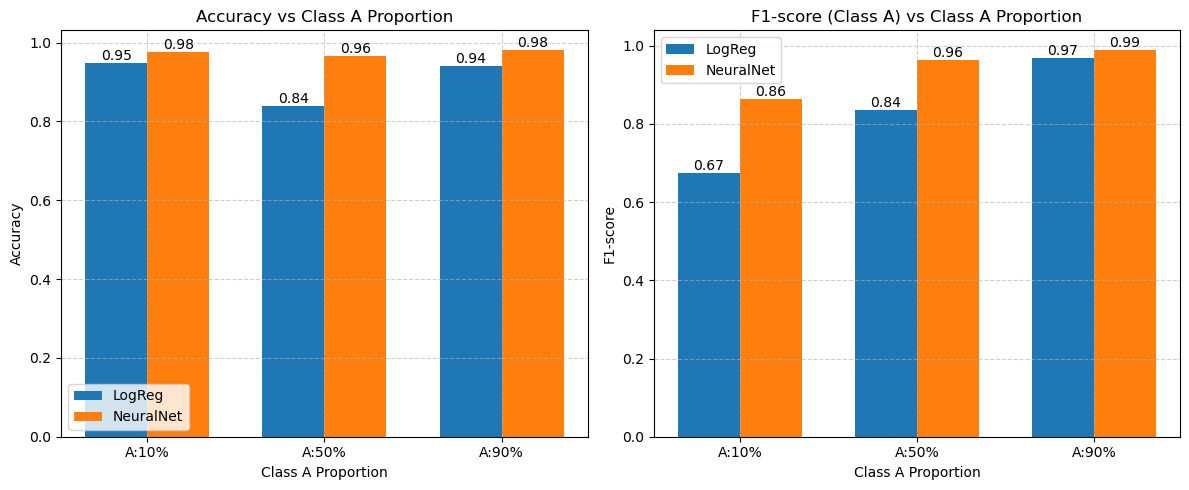

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
ratios_label = ["A:10%", "A:50%", "A:90%"]
acc_lr = [r[1] for r in results_lr]
f1_lr = [r[2] for r in results_lr]
acc_nn = [r[1] for r in results_nn]
f1_nn = [r[2] for r in results_nn]

x = np.arange(len(ratios_label))
bar_width = 0.35

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Compare
bars1 = axs[0].bar(x - bar_width/2, acc_lr, bar_width, label="LogReg")
bars2 = axs[0].bar(x + bar_width/2, acc_nn, bar_width, label="NeuralNet")
axs[0].set_title("Accuracy vs Class A Proportion")
axs[0].set_xlabel("Class A Proportion")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(ratios_label)
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.6)
axs[0].bar_label(bars1, fmt='%.2f')
axs[0].bar_label(bars2, fmt='%.2f')

# F1-score Compare
bars3 = axs[1].bar(x - bar_width/2, f1_lr, bar_width, label="LogReg")
bars4 = axs[1].bar(x + bar_width/2, f1_nn, bar_width, label="NeuralNet")
axs[1].set_title("F1-score (Class A) vs Class A Proportion")
axs[1].set_xlabel("Class A Proportion")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(x)
axs[1].set_xticklabels(ratios_label)
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)
axs[1].bar_label(bars3, fmt='%.2f')
axs[1].bar_label(bars4, fmt='%.2f')

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\imbalance_performance_barchart.png", dpi=300)
plt.show()


## 6. Impact of Neural Network Architecture on Classification Performance 

## 6.1 Single layer with varies units

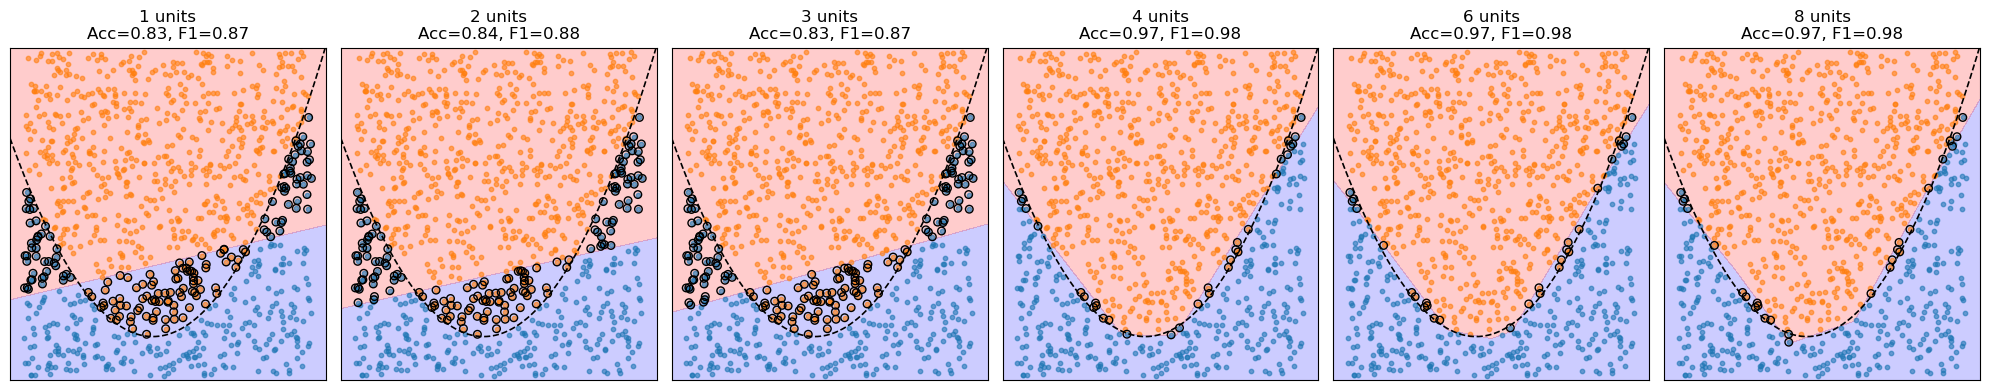

In [34]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset_a1.0.npz data
data = np.load(r"D:\coursework_data\AI_question2\dataset_a1.0.npz")
X_base = data['X']
y_base = data['y']

# List of structures (hidden layer networks)
hidden_sizes = [(1,), (2,), (3,), (4,), (6,), (8,)]

# Graph and result initialization
fig, axs = plt.subplots(1, len(hidden_sizes), figsize=(20, 4))
results = []

# Decision boundary plotting function
def plot_nn_boundary(X, y, hidden_layer_sizes, ax):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, random_state=42))
    ])
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = classification_report(y, y_pred, output_dict=True)['1']['f1-score']
    cm = confusion_matrix(y, y_pred)

    # Decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.6, s=10, label="Class B")
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.6, s=10, label="Class A")
    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label="Misclassified")

    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = a * x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=1.2, label="True Boundary")

    ax.set_title(f"{hidden_layer_sizes[0]} units\nAcc={acc:.2f}, F1={f1:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

    return acc, f1, cm

# Perform training and Plot of each structure
for i, h_size in enumerate(hidden_sizes):
    acc, f1, cm = plot_nn_boundary(X_base, y_base, h_size, axs[i])
    results.append((h_size[0], acc, f1, cm))

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_hidden_layer_comparison.png", dpi=300)
plt.show()

In [35]:
results

[(1,
  0.83,
  0.8712121212121212,
  array([[255,  83],
         [ 87, 575]], dtype=int64)),
 (2,
  0.838,
  0.8796433878157504,
  array([[246,  92],
         [ 70, 592]], dtype=int64)),
 (3,
  0.833,
  0.8749063670411985,
  array([[249,  89],
         [ 78, 584]], dtype=int64)),
 (4,
  0.968,
  0.9758308157099698,
  array([[322,  16],
         [ 16, 646]], dtype=int64)),
 (6,
  0.971,
  0.9779802581624905,
  array([[327,  11],
         [ 18, 644]], dtype=int64)),
 (8,
  0.973,
  0.979529946929492,
  array([[327,  11],
         [ 16, 646]], dtype=int64))]

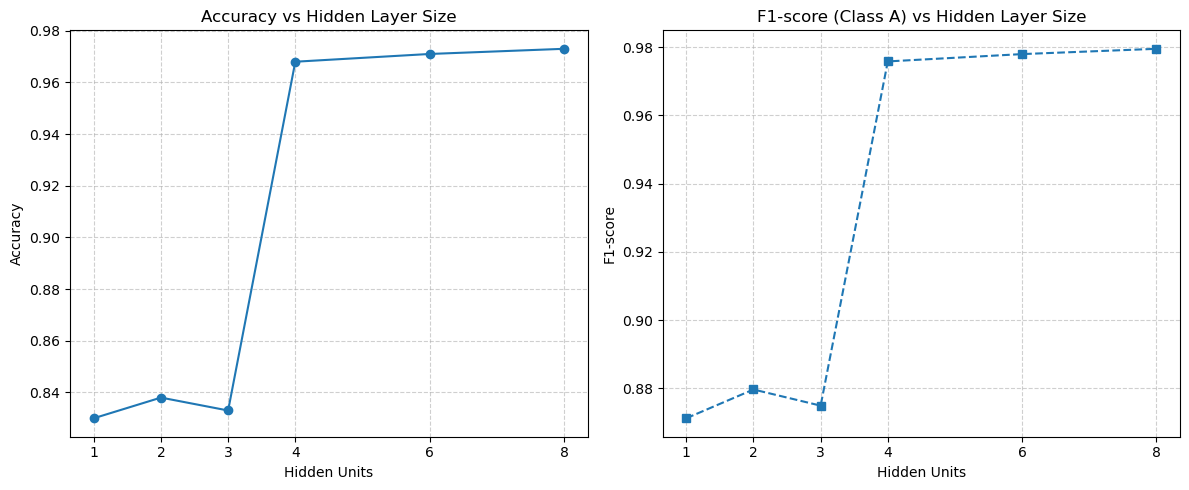

In [36]:
import matplotlib.pyplot as plt

# Extract the structure name, accuracy, and F1
structures = [r[0] for r in results]  # e.g., [1, 2, 4, 6, 8]
accs = [r[1] for r in results]
f1s = [r[2] for r in results]

# Line plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axs[0].plot(structures, accs, marker='o', linestyle='-', label='Accuracy')
axs[0].set_title("Accuracy vs Hidden Layer Size")
axs[0].set_xlabel("Hidden Units")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(structures)
axs[0].grid(True, linestyle="--", alpha=0.6)

# F1-score
axs[1].plot(structures, f1s, marker='s', linestyle='--', label='F1-score')
axs[1].set_title("F1-score (Class A) vs Hidden Layer Size")
axs[1].set_xlabel("Hidden Units")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(structures)
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_hidden_layer_performance_lineplot.png", dpi=300)
plt.show()


## 6.2 Fixed total neurons with different structures 

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


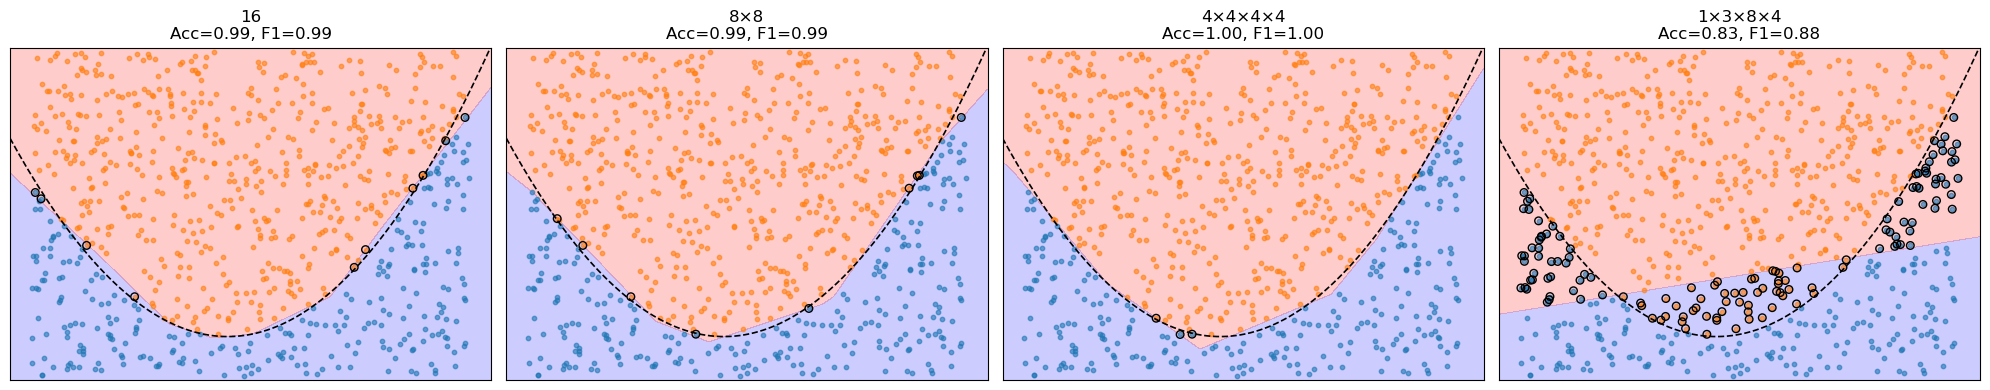

In [60]:
from sklearn.model_selection import train_test_split

# Define a list of structures, all with a total number of 16 neurons, but different layers
depth_variants = [
    (16,),          # 1 hidden layer
    (8, 8),         # 2 hidden layers
    (4, 4, 4, 4),   # 4 hidden layers
    (1, 3, 8, 4),   # asymmetrical structure
]

# Initializes the graph and result record
fig, axs = plt.subplots(1, len(depth_variants), figsize=(20, 4))
depth_results = []

# Initializes the graph and result record
X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)

# Plot + train functions
def plot_nn_depth_boundary(X, y, hidden_layer_sizes, ax):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, random_state=42))
    ])
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = classification_report(y, y_pred, output_dict=True)['1']['f1-score']
    cm = confusion_matrix(y, y_pred)

    # Decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.6, s=10, label="Class B")
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.6, s=10, label="Class A")
    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label="Misclassified")

    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = a * x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=1.2, label="True Boundary")

    label = "×".join(map(str, hidden_layer_sizes))
    ax.set_title(f"{label}\nAcc={acc:.2f}, F1={f1:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

    return acc, f1, cm

# Perform each structure training + visualization
for i, structure in enumerate(depth_variants):
    acc, f1, cm = plot_nn_depth_boundary(X_train, y_train, structure, axs[i])
    depth_results.append((structure, acc, f1, cm))

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_depth_comparison_fixed_total_units.png", dpi=300)
plt.show()


In [61]:
depth_results

[((16,),
  0.9875,
  0.9905482041587902,
  array([[266,   4],
         [  6, 524]], dtype=int64)),
 ((8, 8),
  0.98875,
  0.9914853358561968,
  array([[267,   3],
         [  6, 524]], dtype=int64)),
 ((4, 4, 4, 4),
  0.99625,
  0.9971724787935909,
  array([[268,   2],
         [  1, 529]], dtype=int64)),
 ((1, 3, 8, 4),
  0.83125,
  0.8760330578512396,
  array([[188,  82],
         [ 53, 477]], dtype=int64))]

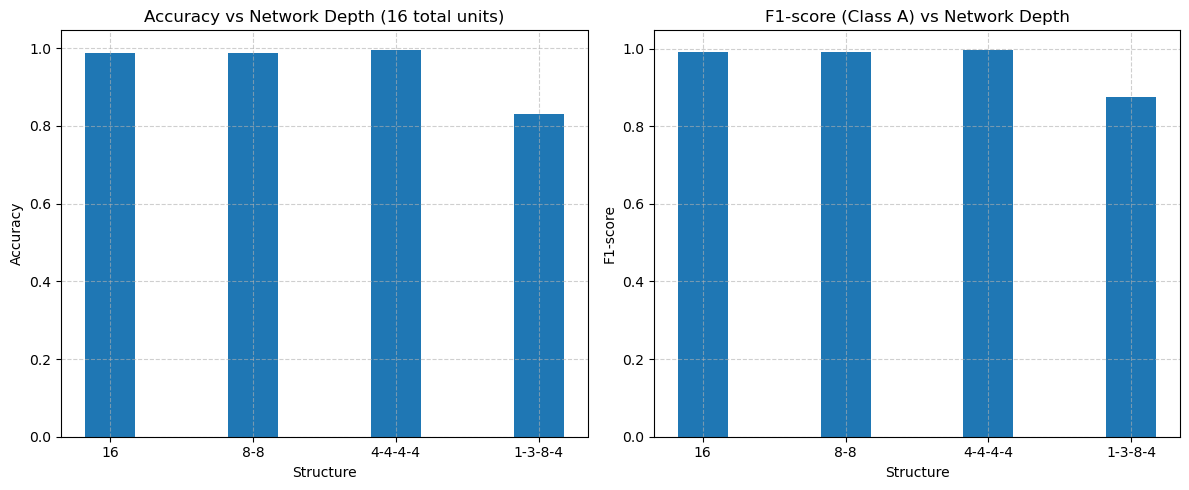

In [64]:
# Extract the structure label, accuracy, and F1
depth_labels = ["16", "8-8", "4-4-4-4", "1-3-8-4"]
accs_depth = [r[1] for r in depth_results]
f1s_depth = [r[2] for r in depth_results]

x = np.arange(len(depth_labels))
bar_width = 0.35

# Bar chart
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy 
axs[0].bar(x, accs_depth, width=bar_width)
axs[0].set_title("Accuracy vs Network Depth (16 total units)")
axs[0].set_xlabel("Structure")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(depth_labels)
axs[0].grid(True, linestyle="--", alpha=0.6)

# F1-score 
axs[1].bar(x, f1s_depth, width=bar_width)
axs[1].set_title("F1-score (Class A) vs Network Depth")
axs[1].set_xlabel("Structure")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(x)
axs[1].set_xticklabels(depth_labels)
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_depth_performance_barchart.png", dpi=300)
plt.show()


## 6.3 Varies number of layers compare(4 neurons each layer)

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


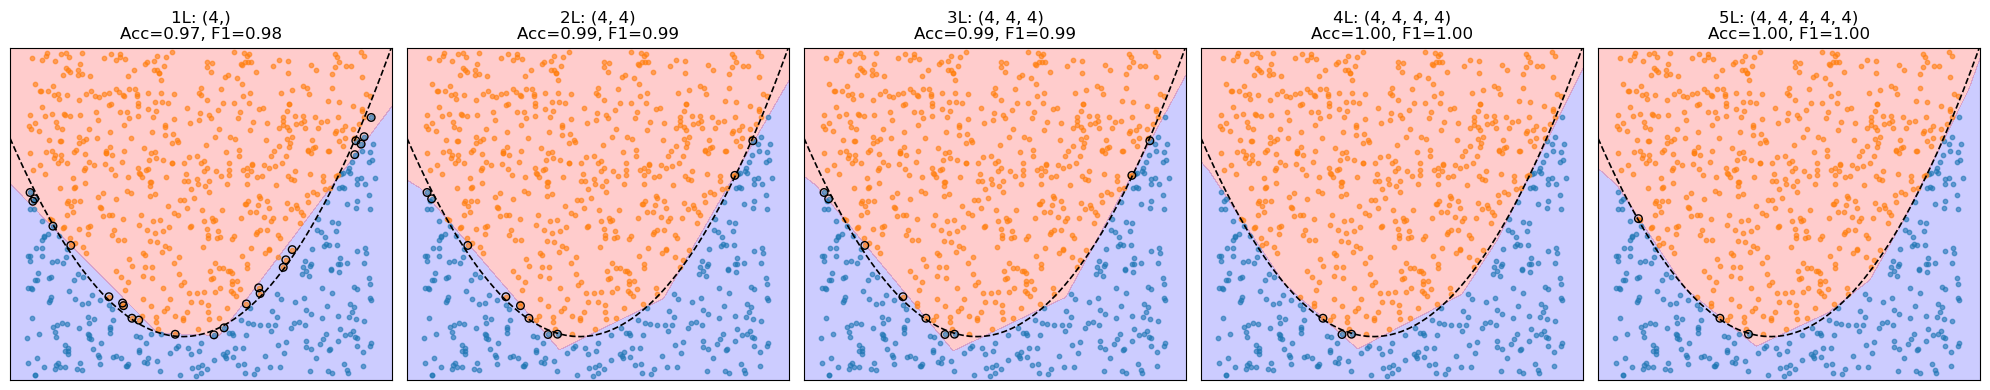

Structure: (4,), Accuracy: 0.9700, F1: 0.9773, Confusion Matrix: [[259, 11], [13, 517]]
Structure: (4, 4), Accuracy: 0.9875, F1: 0.9906, Confusion Matrix: [[265, 5], [5, 525]]
Structure: (4, 4, 4), Accuracy: 0.9888, F1: 0.9915, Confusion Matrix: [[265, 5], [4, 526]]
Structure: (4, 4, 4, 4), Accuracy: 0.9962, F1: 0.9972, Confusion Matrix: [[268, 2], [1, 529]]
Structure: (4, 4, 4, 4, 4), Accuracy: 0.9962, F1: 0.9972, Confusion Matrix: [[269, 1], [2, 528]]


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load data
data = np.load(r"D:\coursework_data\AI_question2\dataset_a1.0.npz")
X_base = data['X']
y_base = data['y']

# Split train set and test set
X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)

# Plot and train
def plot_nn_depth_boundary(X, y, hidden_layer_sizes, ax):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, random_state=42))
    ])
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = classification_report(y, y_pred, output_dict=True)['1']['f1-score']
    cm = confusion_matrix(y, y_pred)

    # boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.6, s=10, label="Class B")
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.6, s=10, label="Class A")
    misclassified = y != y_pred
    ax.scatter(X[misclassified][:, 0], X[misclassified][:, 1],
               edgecolor='black', facecolor='none', s=30, label="Misclassified")

    x_vals = np.linspace(x_min, x_max, 300)
    y_vals = x_vals**2 + x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=1.2, label="True Boundary")

    label = f"{len(hidden_layer_sizes)}L"
    ax.set_title(f"{label}: {hidden_layer_sizes}\nAcc={acc:.2f}, F1={f1:.2f}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

    return acc, f1, cm

# Set the structure: 8 neurons per layer, deepening layer by layer
depth_variants_fixed_width = [
    (4,),
    (4, 4),
    (4, 4, 4),
    (4, 4, 4, 4),
    (4, 4, 4, 4, 4)
]

# Train and plot
fig, axs = plt.subplots(1, len(depth_variants_fixed_width), figsize=(20, 4))
results_fixed_width = []

for i, structure in enumerate(depth_variants_fixed_width):
    acc, f1, cm = plot_nn_depth_boundary(X_train, y_train, structure, axs[i])
    results_fixed_width.append((structure, acc, f1, cm))

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_fixed_width_depth_comparison.png", dpi=300)
plt.show()

# Results
for structure, acc, f1, cm in results_fixed_width:
    print(f"Structure: {structure}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Confusion Matrix: {cm.tolist()}")


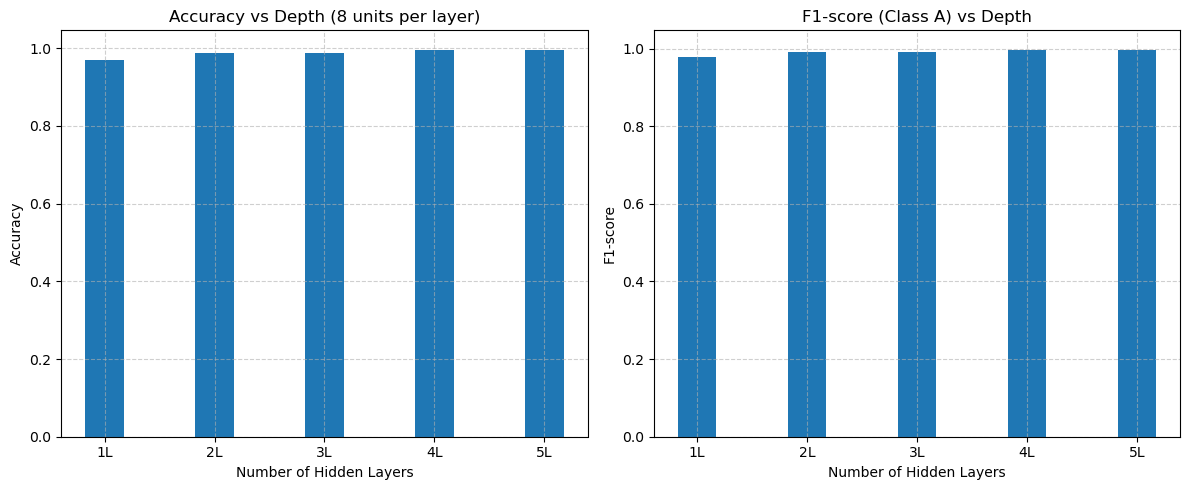

In [71]:
# accuracy and F1-score
depth_labels_fixed_width = ["1L", "2L", "3L", "4L", "5L"]
accs_fixed_width = [r[1] for r in results_fixed_width]
f1s_fixed_width = [r[2] for r in results_fixed_width]

x = np.arange(len(depth_labels_fixed_width))
bar_width = 0.35

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy 
axs[0].bar(x, accs_fixed_width, width=bar_width)
axs[0].set_title("Accuracy vs Depth (8 units per layer)")
axs[0].set_xlabel("Number of Hidden Layers")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(depth_labels_fixed_width)
axs[0].grid(True, linestyle="--", alpha=0.6)

# F1-score 
axs[1].bar(x, f1s_fixed_width, width=bar_width)
axs[1].set_title("F1-score (Class A) vs Depth")
axs[1].set_xlabel("Number of Hidden Layers")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(x)
axs[1].set_xticklabels(depth_labels_fixed_width)
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_fixed_width_depth_barchart.png", dpi=300)
plt.show()


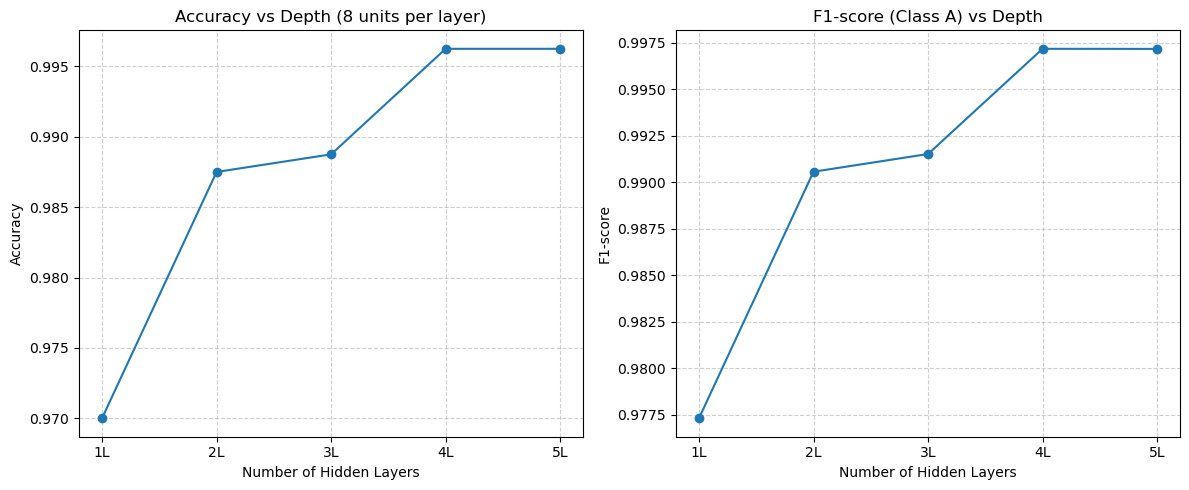

In [74]:
# accuracy and F1-score
depth_labels_fixed_width = ["1L", "2L", "3L", "4L", "5L"]
accs_fixed_width = [r[1] for r in results_fixed_width]
f1s_fixed_width = [r[2] for r in results_fixed_width]

x = np.arange(len(depth_labels_fixed_width))

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy 
axs[0].plot(x, accs_fixed_width, marker='o', linestyle='-')
axs[0].set_title("Accuracy vs Depth (8 units per layer)")
axs[0].set_xlabel("Number of Hidden Layers")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(depth_labels_fixed_width)
axs[0].grid(True, linestyle="--", alpha=0.6)

# F1-score 
axs[1].plot(x, f1s_fixed_width, marker='o', linestyle='-')
axs[1].set_title("F1-score (Class A) vs Depth")
axs[1].set_xlabel("Number of Hidden Layers")
axs[1].set_ylabel("F1-score")
axs[1].set_xticks(x)
axs[1].set_xticklabels(depth_labels_fixed_width)
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"D:\coursework_data\AI_question2\nn_fixed_width_depth_linechart.png", dpi=300)
plt.show()
